In [1]:
from ase.io import read
from sklearn.decomposition import PCA, KernelPCA
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
import numpy as np
from ase.visualize.plot import plot_atoms
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from functools import partial

import sys
sys.path.append('../')

from utils import set_mpl_fonts, set_cmap

set_mpl_fonts()
cmap = set_cmap()

In [2]:
# read in the frames corresponding to these conformers
names = ['chair', 'half-chair', 'twist-boat', 'boat', 'planar']
conf_traj = [read(f'../cyclohexane_data/conformers/{n}.xyz') for n in names]

for frame in conf_traj:

    # wrap each frame in its box
    frame.wrap(eps=1E-10)

    # mask each frame so that descriptors are only centered on carbon (#6) atoms
    mask = np.zeros(len(frame))
    mask[np.where(frame.numbers == 6)[0]] = 1
    frame.arrays['center_atoms_mask'] = mask


In [3]:
hypers = {
    "interaction_cutoff": 4.0,
    "max_radial": 6,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.8,
    "radial_basis": "GTO",
    "global_species": [1, 6],
    "expansion_by_species_method": "user defined",
    "normalize": False
}

soap = SOAP(**hypers)
normalizer = StandardFlexibleScaler(column_wise=False)

conf_soaps = normalizer.fit_transform(soap.transform(conf_traj).get_features(soap))
conf_split_soaps = np.split(conf_soaps, len(conf_traj))
conf_mean_soaps = np.mean(np.split(conf_soaps, len(conf_traj)), axis=1)

In [4]:
gamma = 1.0
k_gamma = partial(pairwise_kernels, metric='rbf', gamma=gamma)

In [5]:
K_gamma = [[np.mean(np.diag(k_gamma(c1, c2))) for c1 in conf_split_soaps]
           for c2 in conf_split_soaps]

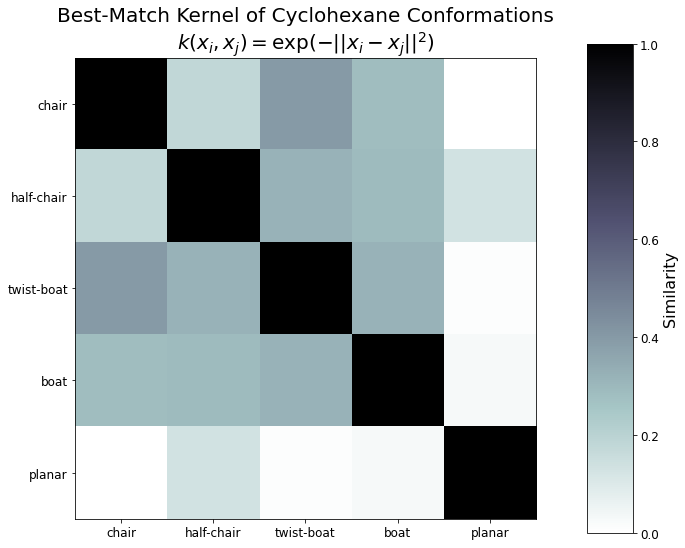

In [6]:
fig, (ax, cax) = plt.subplots(1,
                              2,
                              figsize=(10, 9),
                              gridspec_kw=dict(width_ratios=(1.0, 0.1)))
p = ax.imshow(K_gamma, vmin=0.0, vmax=1.0, cmap='bone_r')
cbar = plt.colorbar(p, cax=cax)
cbar.set_label('Similarity', rotation=90)

ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(names)
ax.set_yticklabels(names)

ax.set_title("Best-Match Kernel of Cyclohexane Conformations\n" +
             r"$k(x_i, x_j) = \mathrm{{exp}}(-||x_i - x_j||^2)$".format(gamma))

plt.savefig('Figure4.pdf')